In [1]:
!pip install boruta
!pip install shap
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import sklearn
from numpy import float16, mean, std
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    KFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load Dataset

file_path = "data"
df = pd.read_excel(file_path)

print("N° of patients: {}".format(len(df)))
print("N° of columns: {}".format(df.shape[1]))
df.head()

N° of patients: 47
N° of columns: 932


,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,0,38,1,Mood abnormalities (depressive),0.67586,42.3566,438.3091,35.4223,438.2523,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,0,41,0,Na,0.70729,105.5166,472.6302,37.2214,466.0998,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,Paziente 3,0,32,0,Na,0.65236,49.4839,407.0018,33.7657,406.9770,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
3,Paziente 4,0,31,1,Seizure,0.65564,44.8080,424.9121,35.6460,424.8701,...,3.0341,0.028616,-6.5858,2.1641,0.020410,2.2997,0.021689,2.0193,0.019045,12.9849
4,Paziente 5,0,43,0,Na,0.76373,94.5834,548.5729,41.4234,547.8604,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [4]:
# Drop unwanted columns

df = df.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 925 


In [5]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = df.columns.difference(['NP-SLE']) 

# Normalize the selected features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [6]:
import random
random.seed(42)  # Set the random seed to 42 for reproducibility

## Random Forest

In [7]:
def train_test(data: pd.DataFrame):
    
    """Return train-test subjects"""

    np_patients = df.loc[df['NP-SLE'] == 1]
    nonp_patients = df.loc[df['NP-SLE'] == 0]
    hc_patients = df.loc[df['NP-SLE'] == 2]


    print(f"number of neuro patients: {len(np_patients)}")
    print(f"number of non neuro patients: {len(nonp_patients)}")
    print(f"number of non neuro patients: {len(hc_patients)}")


    number_of_train_nonp = math.floor(0.8 * len(nonp_patients))  # = 
    number_of_train_np = math.floor(0.8 * len(np_patients))
    number_of_train_hc = math.floor(0.8 * len(hc_patients))  # = 
    train_nonp = nonp_patients[:number_of_train_nonp]
    train_np = np_patients[:number_of_train_np]
    train_hc = hc_patients[:number_of_train_hc]

    test_nonp = nonp_patients[number_of_train_nonp:]
    test_np = np_patients[number_of_train_np:]
    test_hc = hc_patients[number_of_train_hc:]

    assert len(train_nonp) + len(test_nonp) == len(nonp_patients)
    assert len(train_np) + len(test_np) == len(np_patients)
    assert len(train_hc) + len(test_hc) == len(hc_patients)

    train = pd.concat([train_np, train_nonp, train_hc])
    test = pd.concat([test_np, test_nonp, test_hc])

    return train, test

In [8]:
train, test = train_test(df)
X_train = train.loc[:,:]
X_test = test.loc[:,:]
y_train = train.pop("NP-SLE")
y_test = test.pop("NP-SLE")

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

number of neuro patients: 14
number of non neuro patients: 13
number of non neuro patients: 20
Accuracy:  0.8


In [9]:
ConfusionMatrix = metrics.confusion_matrix(y_test, y_pred)
print(ConfusionMatrix)

[[1 2 0]
 [0 3 0]
 [0 0 4]]


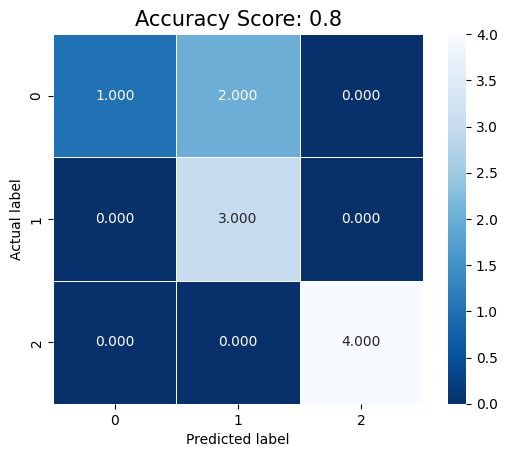

In [10]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

## RF_2

In [11]:
target = df['NP-SLE']
inputs = df.drop(['NP-SLE'], axis = 'columns')
x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.20, random_state=10)

In [12]:
from boruta import BorutaPy
np.int = int  # Override np.int with int

x = x_train.values
y = y_train.values
y = y.ravel()

rf_boruta = RandomForestClassifier(n_jobs=-1, class_weight={0: 1, 1: 3}, max_depth=3)
feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=0, random_state=42, perc=0.3)
feat_selector.fit(x, y)

cols = inputs.columns[feat_selector.support_]
print("N° of selected features: {}".format(len(cols)))
print(cols)


N° of selected features: 628
Index(['White Matter (WM) volume cm3', 'White Matter (WM) volume %',
       'Normal Appearing White Matter volume cm3',
       'Normal Appearing White Matter volume %',
       'Abnormal Appearing White Matter volume cm3',
       'Abnormal Appearing White Matter volume %',
       'Grey Matter (GM) volume cm3', 'Subcortical Grey Matter volume %',
       'Cortical Grey Matter volume cm3', 'Cerebellar Grey Matter volume cm3',
       ...
       'PIns left thickness mm', 'PIns thickness asymmetry',
       'CO left thickness mm', 'CO left thickness norm.',
       'CO thickness asymmetry', 'FO thickness asymmetry',
       'PO right thickness mm', 'PO left thickness mm',
       'PO left thickness norm.', 'PO thickness asymmetry'],
      dtype='object', length=628)


In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Define the class weights based on the training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary of class weights
class_weight = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight)

{0: 1.121212121212121, 1: 1.121212121212121, 2: 0.8222222222222222}


In [14]:
from sklearn.model_selection import RandomizedSearchCV

# The function to measure the quality of a split
criterion = ['gini', 'entropy']

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=50, num=5)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(14, 30, num=2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6]

max_leaf_nodes = [None, 2, 3, 4, 5, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {
    'criterion': criterion,
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_leaf_nodes': max_leaf_nodes,
    'bootstrap': bootstrap
}

# First create the base model to tune
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight=class_weight
)

# Random search of parameters, using 5 fold cross validation, different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=500,
    cv=5
)

# Fit the random search model
rf_random.fit(x_train, y_train)
rf_random.best_params_

{'n_estimators': 27,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'gini',
 'bootstrap': False}

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, recall_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, balanced_accuracy_score


rf = RandomForestClassifier(random_state=20,
                            criterion='gini',
                            n_estimators=20,
                            min_samples_split=4,
                            min_samples_leaf=1,
                            max_leaf_nodes=None,
                            max_features='sqrt',
                            max_depth=14,
                            bootstrap=True)

rf.fit(x_train, y_train)
print("Trained\n")

y_predicted = rf.predict(x_test)
cm_rf = confusion_matrix(y_test, y_predicted)
print(cm_rf, "\n")

print('1. The F-1 Score of the model: {}\n'.format(round(f1_score(y_test, y_predicted, average='macro'), 2)))
print('2. The Recall Score of the model: {}\n'.format(round(recall_score(y_test, y_predicted, average='macro'), 2)))
print('3. Classification report:\n{}\n'.format(classification_report(y_test, y_predicted)))

accuracy = accuracy_score(y_test, y_predicted)
print('Accuracy:', accuracy)

f1 = f1_score(y_test, y_predicted, average='macro')  # 'macro' computes the unweighted mean of F1 scores
print('F1-Score:', f1)

recall = recall_score(y_test, y_predicted, average='macro')
print('Recall:', recall)

precision = precision_score(y_test, y_predicted, average='macro')
print('Precision:', precision)

balanced_accuracy = balanced_accuracy_score(y_test, y_predicted)
print('Balanced Accuracy:', balanced_accuracy)

Trained

[[2 0 0]
 [2 1 0]
 [0 0 5]] 

1. The F-1 Score of the model: 0.72

2. The Recall Score of the model: 0.78

3. Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.33      0.50         3
           2       1.00      1.00      1.00         5

    accuracy                           0.80        10
   macro avg       0.83      0.78      0.72        10
weighted avg       0.90      0.80      0.78        10


Accuracy: 0.8
F1-Score: 0.7222222222222222
Recall: 0.7777777777777777
Precision: 0.8333333333333334
Balanced Accuracy: 0.7777777777777777


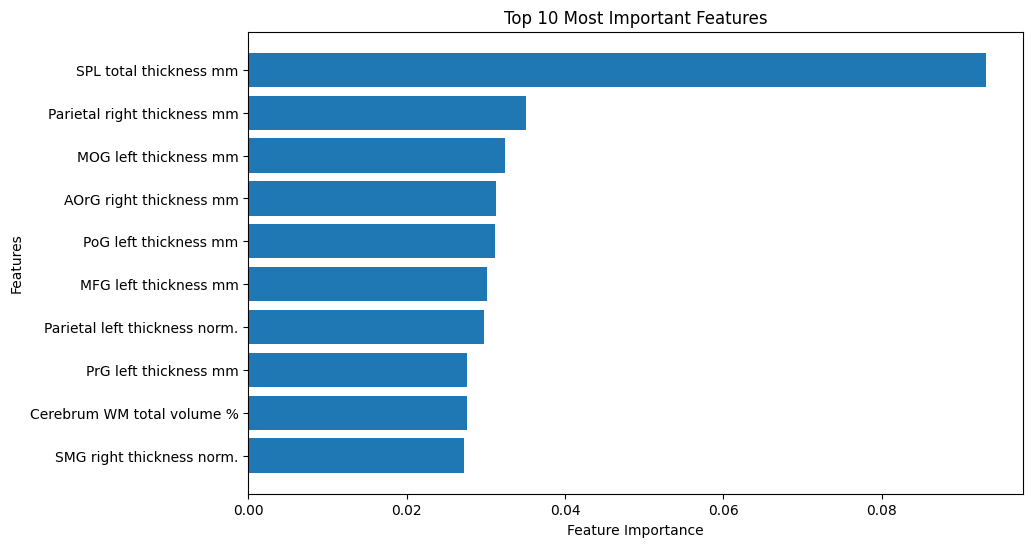

In [16]:
# Get the feature importances
importances = rf.feature_importances_

# Get the indices of the top 10 most important features
top_indices = np.argsort(importances)[-10:]

# Get the names of the top 10 most important features
top_features = inputs.columns[top_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), importances[top_indices], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features')
plt.show()